# Interrogate PCMDI-AMIP-1-1-9 data - generate PCMDI-AMIP-1-1-10
<div style="text-align: right">
<p>
    <img src="https://pcmdi.github.io/assets/PCMDI/199x65px-PCMDI-Logo-Text-rectangle.png"
         width="91"
         height="30"
         class="fixed-height-image"
         style="margin-right: 20px"
         title="Program for Climate Model Diagnosis and Intercomparison"
         alt="Program for Climate Model Diagnosis and Intercomparison"
    >&nbsp;
    <img src="https://pcmdi.github.io/assets/LLNL/212px-LLNLiconPMS286-WHITEBACKGROUND.png"
         width="30"
         height="30"
         class="fixed-height-image"
         style="margin-right: 20px"
         title="Lawrence Livermore National Laboratory"
         alt="Lawrence Livermore National Laboratory"
    >&nbsp;
    <img src="https://pcmdi.github.io/assets/DOE/459x127px-DOE-Logo_Color_TextOnly.png"
         width="108"
         height="30"
         class="fixed-height-image"
         style="margin-right: 20px"
         title="United States Department of Energy"
         alt="United States Department of Energy"
    >
</p>
</div>

## Notes
- ascertain issues due to upstream OISSTv2.0 problems
- generate infill values for the problem siconc Dec-2022 value

**Summary**

Quick and dirty notebook to plot PCMDI-AMIP-1-1-9 data to ascertain if issues exist

**Authors**

Paul J. Durack ([durack1](https://github.com/durack1); [PCMDI](https://pcmdi.llnl.gov/), [Lawrence Livermore National Laboratory](https://www.llnl.gov/))

**Notes**

PJD  4 Mar 2024 - Started<br>
PJD 21 Jul 2025 - Remapped all data paths to NERSC holdings<br>
PJD 21 Jul 2025 - Generated updated input file with "fixed" 2022-12<br>
PJD 29 Jul 2025 - Updated to build a Dec-22 fix from 5-year climatologies Nov, Dec, Jan, infilling Dec-22 with Nov-22/Jan-23 average anomalies<br>
PJD 30 Jul 2025 - Updated with new anomaly-climatology-based infill<br>
PJD  4 Aug 2025 - Updated again with write-out to SST_1-1-10 subdir

**ToDo**

**Links**

### imports

In [1]:
%%time
import cartopy.crs as ccrs
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import xarray as xr
import xcdat as xc
from IPython.display import display, Markdown
print("software versions:", xc.__version__, ";", xr.__version__, ";", np.__version__)

software versions: 0.9.1 ; 2025.7.1 ; 2.2.6
CPU times: user 8.84 s, sys: 1.15 s, total: 9.99 s
Wall time: 9.9 s


### load published PCMDI-AMIP-1-1-9 data and check that

In [2]:
%%time
#input4MIPsPath = "/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9"
input4MIPsPath = "/global/cfs/projectdirs/m4931/gsharing/user_pub_work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9"
tosPath = "ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc"
siconcPath = "seaIce/mon/siconc/gn/v20230512/siconc_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc"
maskPath = "ocean/fx/sftof/gn/v20230512/sftof_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn.nc"
t1 = xc.open_dataset(os.path.join(input4MIPsPath, tosPath))
s1 = xc.open_dataset(os.path.join(input4MIPsPath, siconcPath))
m1 = xc.open_dataset(os.path.join(input4MIPsPath, maskPath), decode_times=False)

CPU times: user 108 ms, sys: 91.4 ms, total: 199 ms
Wall time: 215 ms


### check tos, unmasked and masked - checks out ok

### 👉 SST values check out ok

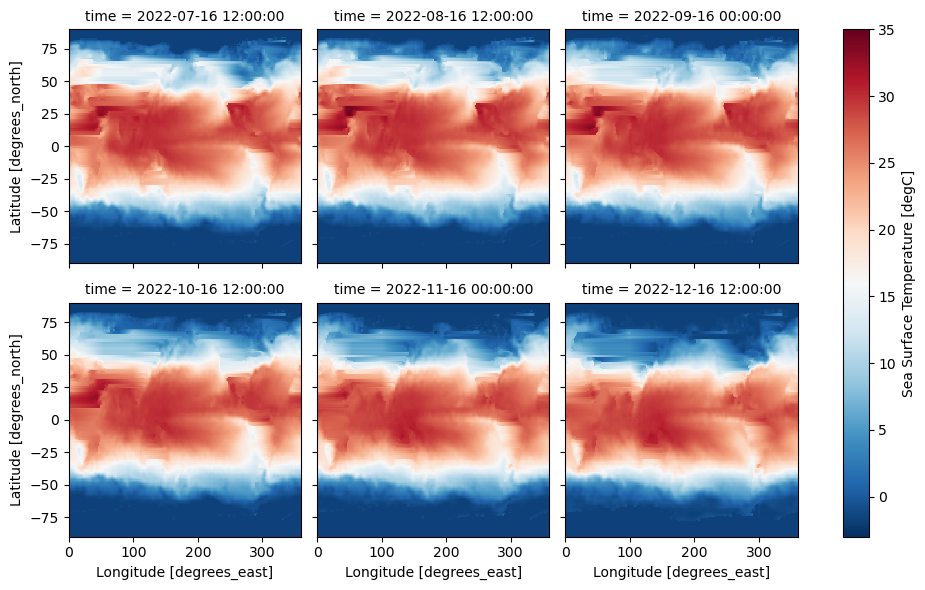

In [3]:
display(Markdown("### 👉 SST values check out ok"))
t1["tos"].isel(time=slice(-6, None)).plot(
    col="time", col_wrap=3, cmap="RdBu_r", vmin=-3, vmax=35
)

### 👉 SST values check out ok - look even better masked

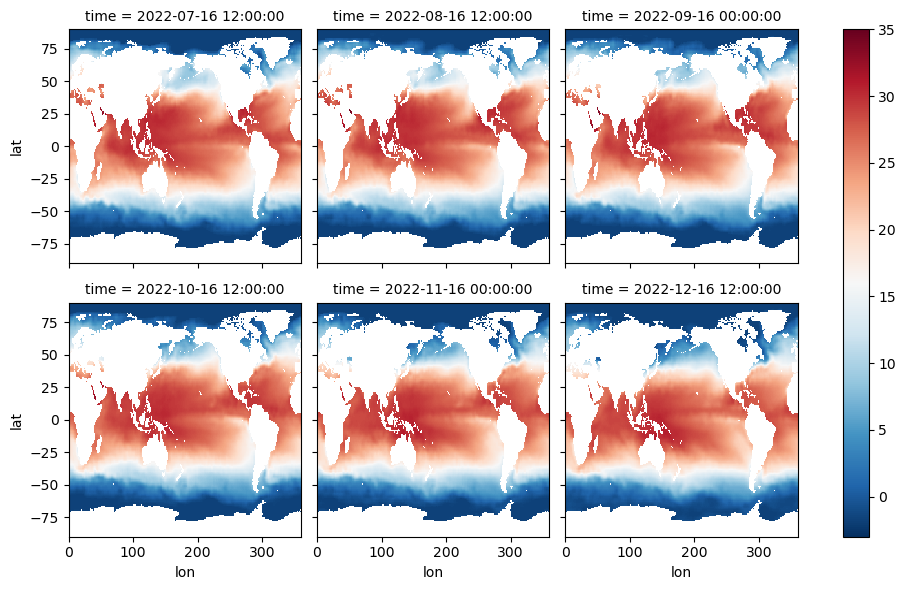

In [4]:
# apply landsea mask
tos = xr.where(
    m1["sftof"] == 100, t1["tos"], np.nan
)  # mask where land, otherwise sea ice
display(Markdown("### 👉 SST values check out ok - look even better masked"))
tos.isel(time=slice(-6, None)).plot(
    col="time", col_wrap=3, cmap="RdBu_r", vmin=-3, vmax=35
)

### check siconc, unmasked and masked - problem 2022-12

### 👉 siconc values look good until 2022-12

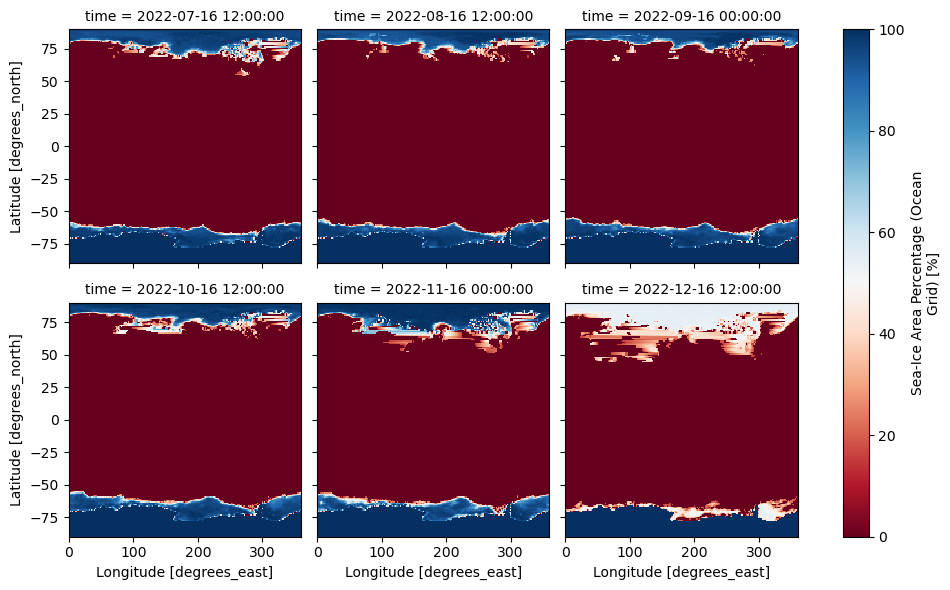

In [5]:
display(Markdown("### 👉 siconc values look good until 2022-12"))
s1["siconc"].isel(time=slice(-6, None)).plot(col="time", col_wrap=3, cmap="RdBu")

### 👉 siconc values look good until 2022-12 - even more prominent issue when masked

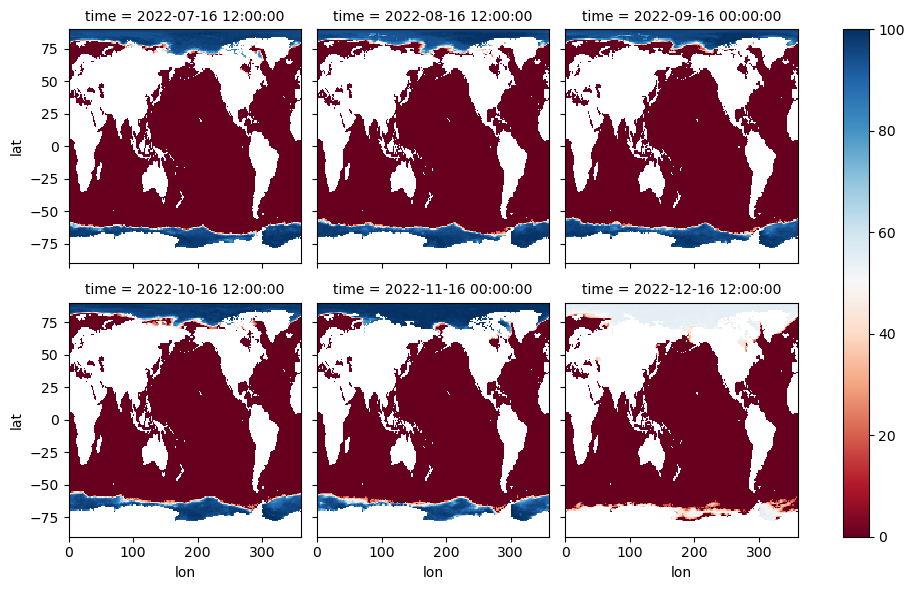

In [ ]:
# apply landsea mask
siconc = xr.where(
    m1["sftof"] == 100, s1["siconc"], np.nan
)  # mask where land, otherwise sea ice
display(
    Markdown(
        "### 👉 siconc values look good until 2022-12 - even more prominent issue when masked"
    )
)
siconc.isel(time=slice(-6, None)).plot(col="time", col_wrap=3, cmap="RdBu")

### what options are there for replacement?

### 👉 siconc values 2021-10 through 2022-11 look good, as does 2023-01

CPU times: user 616 ms, sys: 60.1 ms, total: 676 ms
Wall time: 675 ms


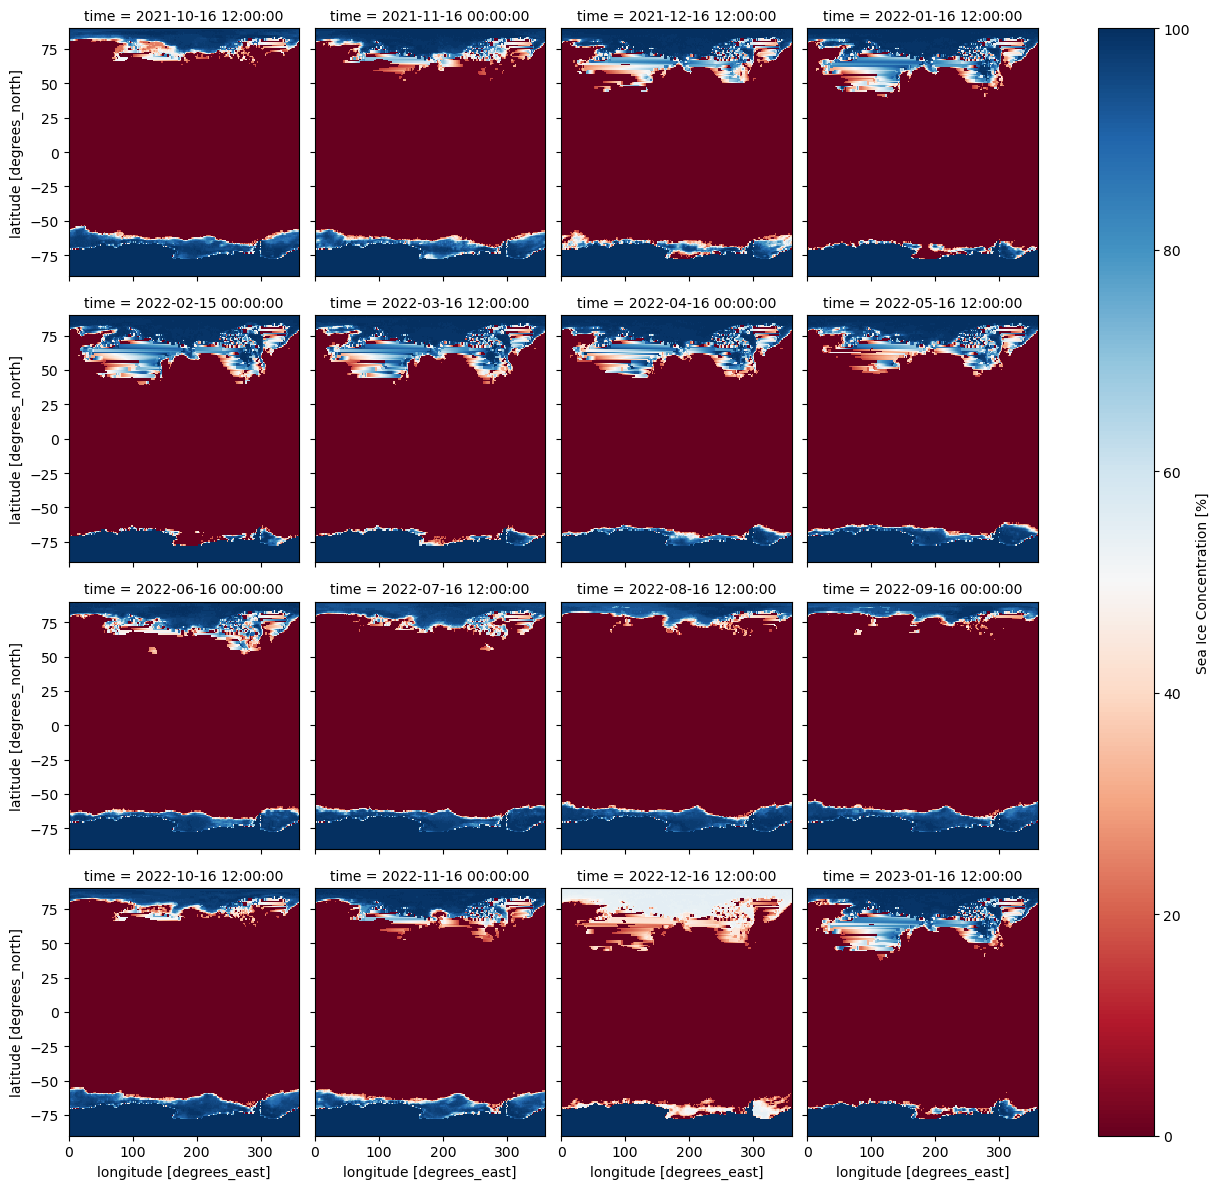

In [7]:
%%time
#homePath = "/p/user_pub/climate_work/durack1/Shared/150219_AMIPForcingData"
homePath = "/pscratch/sd/d/durack1/Shared/150219_AMIPForcingData"
ds3 = xc.open_dataset(
    os.path.join(
        homePath, "SST_1-1-9-release/MODEL.ICE.HAD187001-198110.OI198111-202301.nc"
    )
)
sftof = xc.open_dataset(
    os.path.join(
        input4MIPsPath,
        "ocean/fx/sftof/gn/v20230512/sftof_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn.nc",
    ),
    decode_times=False,
)
ocn = sftof["sftof"]
sic = ds3["SEAICE"]
# plot siconc without mask
display(Markdown("### 👉 siconc values 2021-10 through 2022-11 look good, as does 2023-01"))
sic.isel(time=slice(-16, None)).plot(col="time", col_wrap=4, cmap="RdBu")

### 👉 Problem month Dec-22 vs Nov-22 and Jan-23 straddling months

CPU times: user 514 ms, sys: 1.01 s, total: 1.53 s
Wall time: 1.53 s


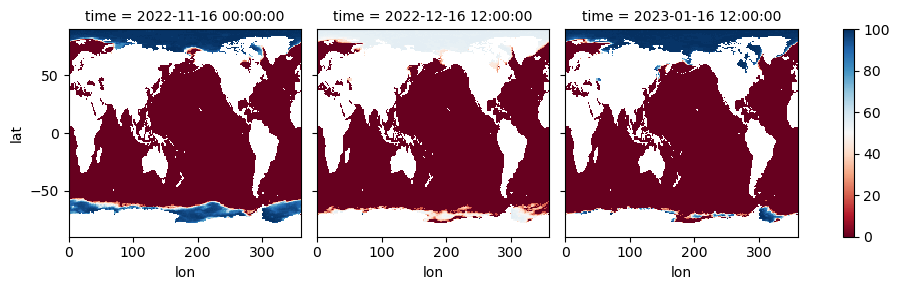

In [8]:
%%time
ice = xr.where(ocn == 100, sic, np.nan)  # mask where land, otherwise sea ice
display(Markdown("### 👉 Problem month Dec-22 vs Nov-22 and Jan-23 straddling months"))
ice.isel(time=slice(-3, None)).plot(col="time", col_wrap=3, cmap="RdBu")

### how does a temporal average of Nov-22 and Jan-23 look?

### 👉 Simple nearest-neighbour - Nov-22 and Jan-23 average infill

CPU times: user 33.6 ms, sys: 0 ns, total: 33.6 ms
Wall time: 32.2 ms


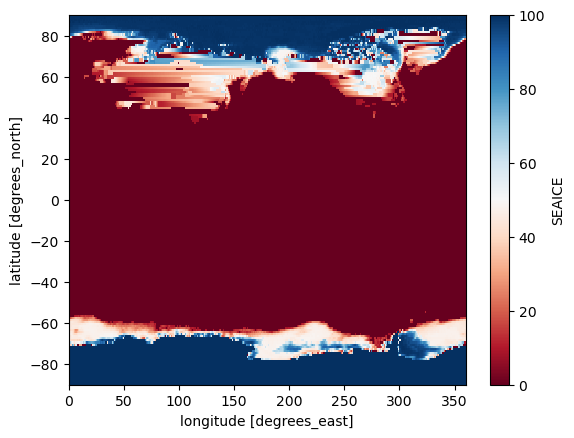

In [9]:
%%time
NovDecJan = sic.sel(time=ice.time[[-3, -2, -1]])  # new matrix Nov-22, Dec-22, Jan-23
NovAndJan = sic.sel(time=ice.time[[-3, -1]])  # pull out Nov-22 and Jan-23
newDec = NovAndJan.mean(dim="time")
display(Markdown("### 👉 Simple nearest-neighbour - Nov-22 and Jan-23 average infill"))
newDec.plot(cmap="RdBu")

### How about a more comprehensive solution - climatologies and anomaly averaging

### Calculate 5-year climatologies - November and January

### 👉 November climatologies - Nov-18 through Nov-22 and average

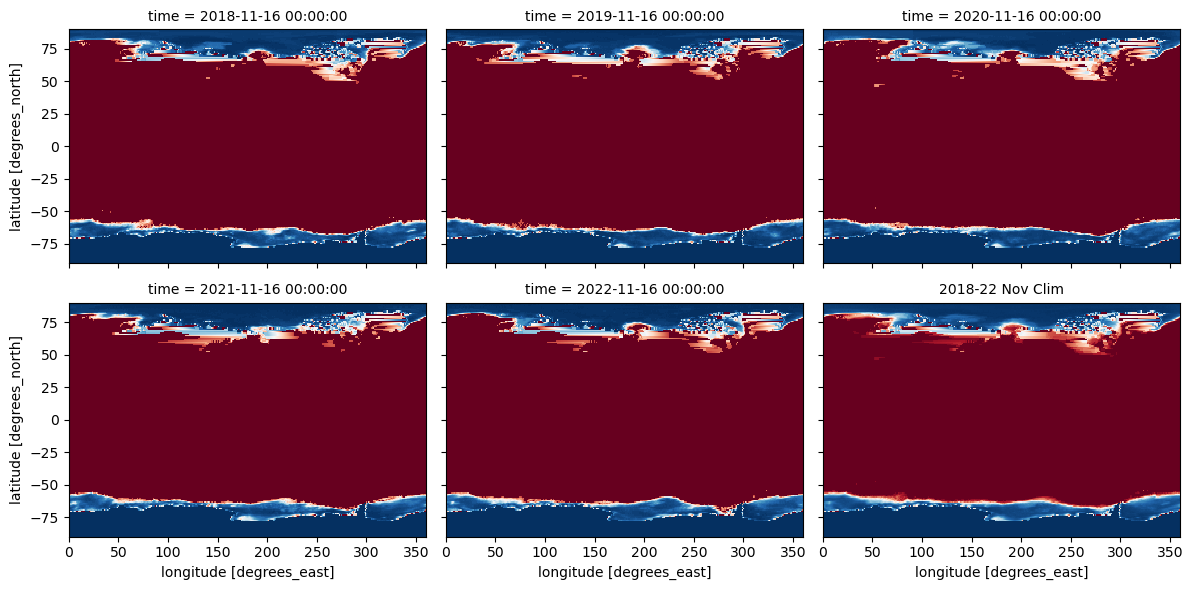

### 👉 December climatologies - Dec-19 through Dec-21 and average

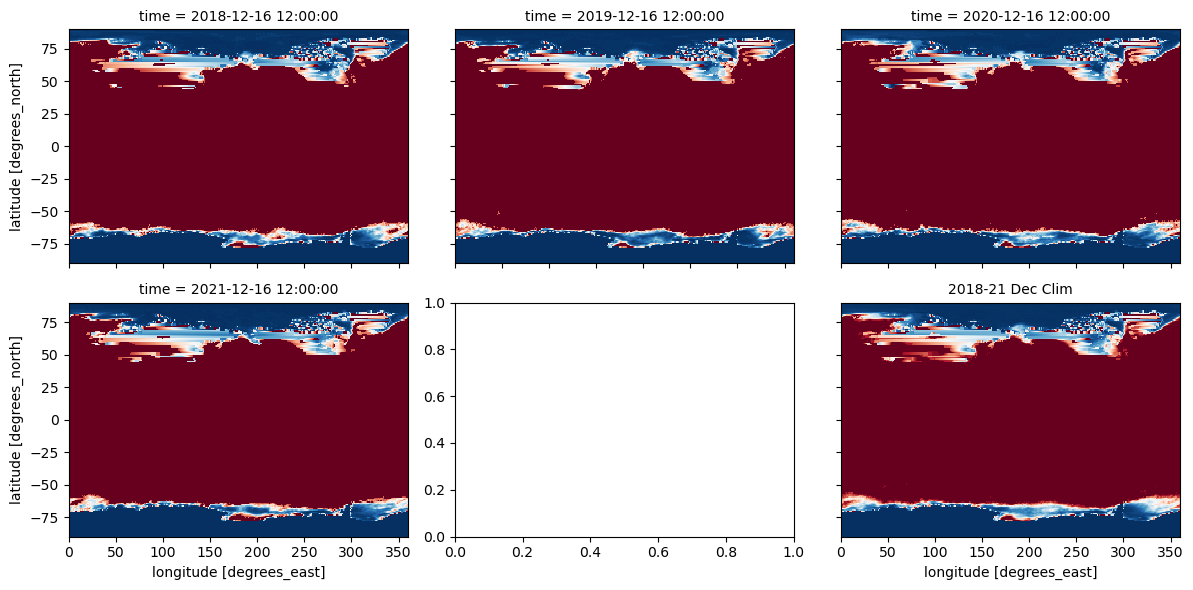

### 👉 January climatologies - Jan-19 through Jan-23 and average

CPU times: user 1.54 s, sys: 169 ms, total: 1.71 s
Wall time: 1.71 s


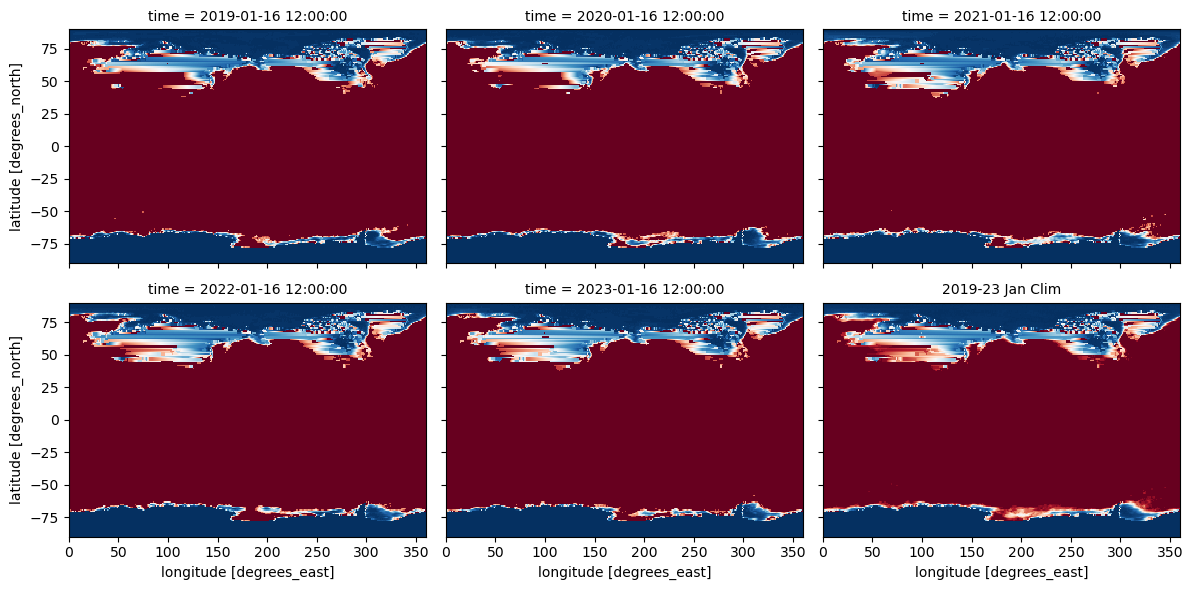

In [10]:
%%time
# calculate a 2018 through 2022 climatological November
Nov18to22 = sic.sel(time=ice.time[[-51, -39, -27, -15, -3]])  # new matrix Nov-18, Nov-19, Nov-20, Nov-21, Nov-22
climNov = Nov18to22.mean(dim="time")

labels = [f"time = {t.year:04d}-{t.month:02d}-{t.day:02d} {t.hour:02d}:{t.minute:02d}:{t.second:02d}" for t in Nov18to22.time.values]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
# Plot the 5 time slices
display(Markdown("### 👉 November climatologies - Nov-18 through Nov-22 and average"))
for i in range(5):
    a = Nov18to22.isel(time=i).plot(ax=axes.flat[i], cmap="RdBu", add_colorbar=False)
    if i < 3:
        axes.flat[i].set_xticklabels([])
        axes.flat[i].set_xlabel("")
    if i not in [0, 3]:
        axes.flat[i].set_yticklabels([])
        axes.flat[i].set_ylabel("")
    axes.flat[i].set_title(labels[i], fontsize=10)
# Plot the extra 2D array
climNov.plot(ax=axes.flat[5], cmap="RdBu", add_colorbar=False)
axes.flat[5].set_title("2018-22 Nov Clim", fontsize=10)
axes.flat[5].set_yticklabels([])
axes.flat[5].set_ylabel("")
fig.tight_layout()
plt.show()

# calculate a 2018 through 2021 climatological December (Dec-22 is problematic)
Dec18to21 = sic.sel(time=ice.time[[-50, -38, -26, -14]])  # new matrix Jan-19, Jan-20, Jan-21, Jan-22, Jan-23
climDec = Dec18to21.mean(dim="time")

labels = [f"time = {t.year:04d}-{t.month:02d}-{t.day:02d} {t.hour:02d}:{t.minute:02d}:{t.second:02d}" for t in Dec18to21.time.values]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
# Plot the 5 time slices
display(Markdown("### 👉 December climatologies - Dec-19 through Dec-21 and average"))
for i in range(4):
    a = Dec18to21.isel(time=i).plot(ax=axes.flat[i], cmap="RdBu", add_colorbar=False)
    if i < 3:
        axes.flat[i].set_xticklabels([])
        axes.flat[i].set_xlabel("")
    if i not in [0, 3]:
        axes.flat[i].set_yticklabels([])
        axes.flat[i].set_ylabel("")
    axes.flat[i].set_title(labels[i], fontsize=10)
# Plot the extra 2D array
climDec.plot(ax=axes.flat[5], cmap="RdBu", add_colorbar=False)
axes.flat[5].set_title("2018-21 Dec Clim", fontsize=10)
axes.flat[5].set_yticklabels([])
axes.flat[5].set_ylabel("")
fig.tight_layout()
plt.show()

# calculate a 2019 through 2023 climatological January
Jan19to23 = sic.sel(time=ice.time[[-49, -37, -25, -13, -1]])  # new matrix Jan-19, Jan-20, Jan-21, Jan-22, Jan-23
climJan = Jan19to23.mean(dim="time")

labels = [f"time = {t.year:04d}-{t.month:02d}-{t.day:02d} {t.hour:02d}:{t.minute:02d}:{t.second:02d}" for t in Jan19to23.time.values]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
# Plot the 5 time slices
display(Markdown("### 👉 January climatologies - Jan-19 through Jan-23 and average"))
for i in range(5):
    a = Jan19to23.isel(time=i).plot(ax=axes.flat[i], cmap="RdBu", add_colorbar=False)
    if i < 3:
        axes.flat[i].set_xticklabels([])
        axes.flat[i].set_xlabel("")
    if i not in [0, 3]:
        axes.flat[i].set_yticklabels([])
        axes.flat[i].set_ylabel("")
    axes.flat[i].set_title(labels[i], fontsize=10)
# Plot the extra 2D array
climJan.plot(ax=axes.flat[5], cmap="RdBu", add_colorbar=False)
axes.flat[5].set_title("2019-23 Jan Clim", fontsize=10)
axes.flat[5].set_yticklabels([])
axes.flat[5].set_ylabel("")
fig.tight_layout()

### Calculate 5-year anomalies - November and January

### 👉 November anomalies - Nov-18 through Nov-22 and average

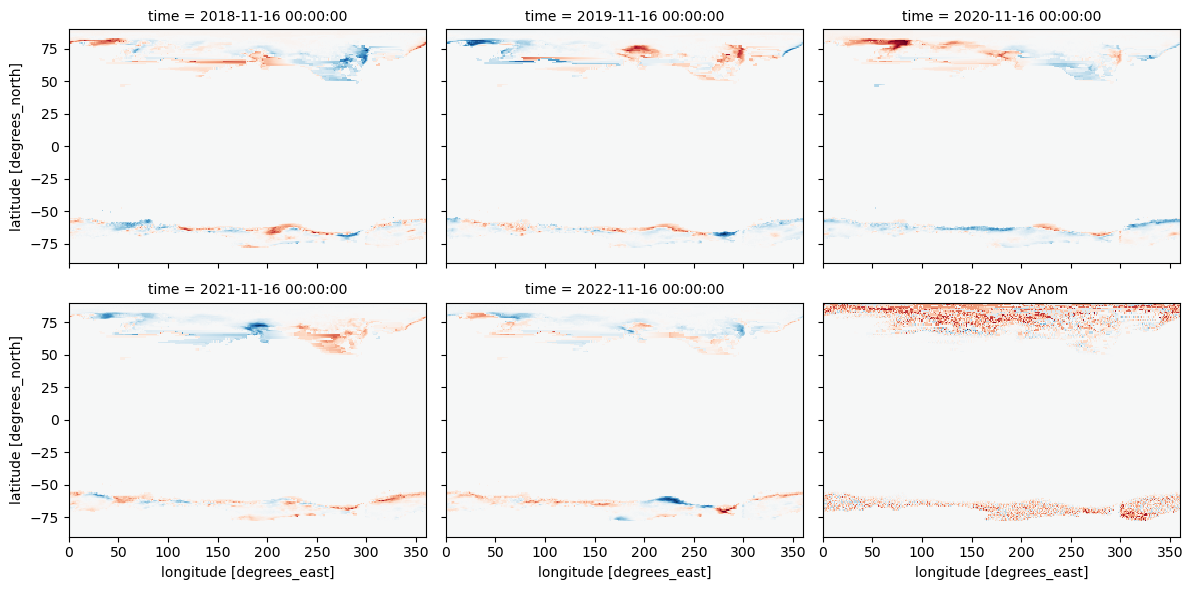

### 👉 January anomalies - Jan-19 through Jan-23 and average

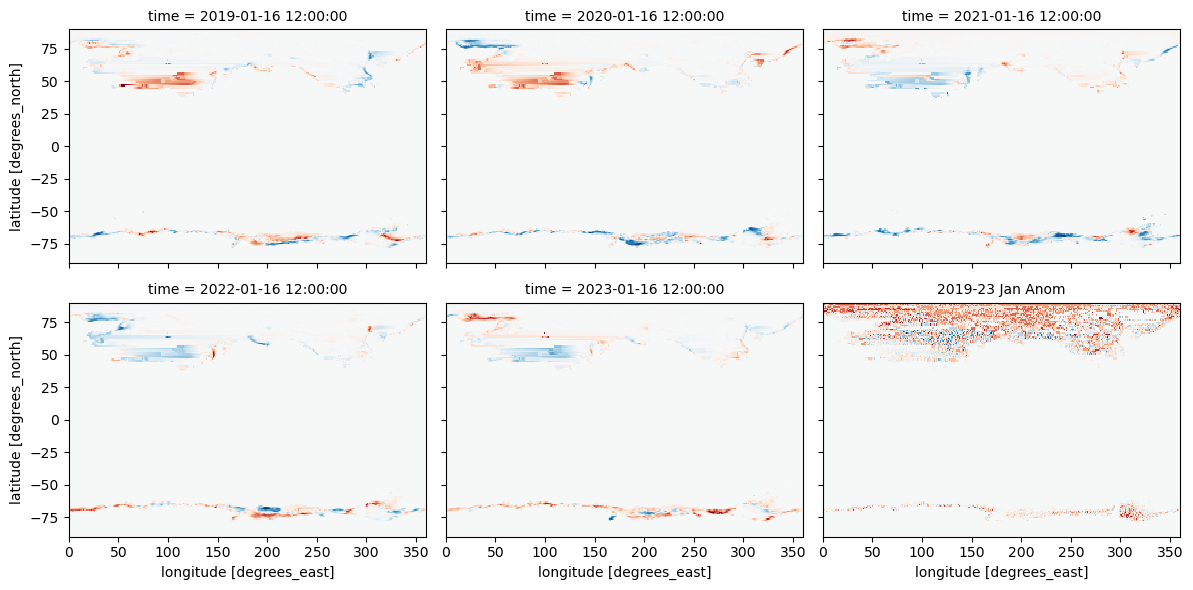

### 👉 Target month anomalies - Nov, Dec-infilled, Jan

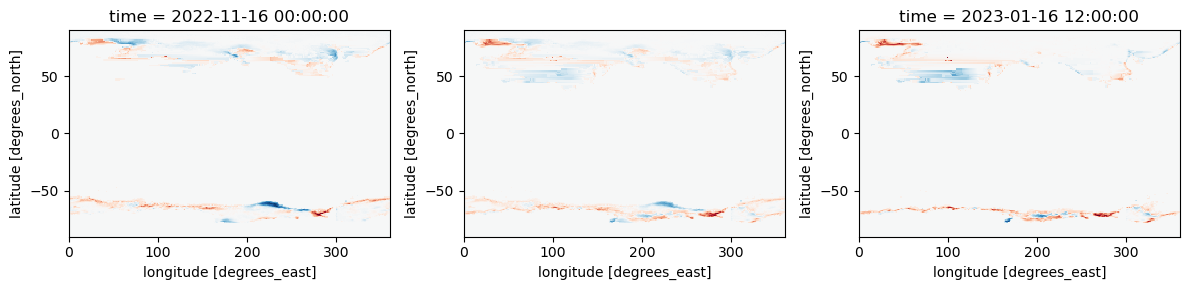

CPU times: user 1.59 s, sys: 88.3 ms, total: 1.68 s
Wall time: 1.71 s


In [11]:
%%time
# calculate a 2018 through 2022 anomalous November
Nov18to22anom = Nov18to22 - climNov
anomNov = Nov18to22anom.mean(dim="time")

labels = [f"time = {t.year:04d}-{t.month:02d}-{t.day:02d} {t.hour:02d}:{t.minute:02d}:{t.second:02d}" for t in Nov18to22anom.time.values]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
# Plot the 5 time slices
display(Markdown("### 👉 November anomalies - Nov-18 through Nov-22 and average"))
for i in range(5):
    a = Nov18to22anom.isel(time=i).plot(ax=axes.flat[i], cmap="RdBu", add_colorbar=False)
    if i < 3:
        axes.flat[i].set_xticklabels([])
        axes.flat[i].set_xlabel("")
    if i not in [0, 3]:
        axes.flat[i].set_yticklabels([])
        axes.flat[i].set_ylabel("")
    axes.flat[i].set_title(labels[i], fontsize=10)
# Plot the extra 2D array
anomNov.plot(ax=axes.flat[5], cmap="RdBu", add_colorbar=False)
axes.flat[5].set_title("2018-22 Nov Anom", fontsize=10)
axes.flat[5].set_yticklabels([])
axes.flat[5].set_ylabel("")
fig.tight_layout()
plt.show()

# calculate a 2019 through 2023 anomalous January
Jan19to23anom = Jan19to23 - climJan
anomJan = Jan19to23anom.mean(dim="time")

labels = [f"time = {t.year:04d}-{t.month:02d}-{t.day:02d} {t.hour:02d}:{t.minute:02d}:{t.second:02d}" for t in Jan19to23anom.time.values]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
# Plot the 5 time slices
display(Markdown("### 👉 January anomalies - Jan-19 through Jan-23 and average"))
for i in range(5):
    a = Jan19to23anom.isel(time=i).plot(ax=axes.flat[i], cmap="RdBu", add_colorbar=False)
    if i < 3:
        axes.flat[i].set_xticklabels([])
        axes.flat[i].set_xlabel("")
    if i not in [0, 3]:
        axes.flat[i].set_yticklabels([])
        axes.flat[i].set_ylabel("")
    axes.flat[i].set_title(labels[i], fontsize=10)
# Plot the extra 2D array
anomJan.plot(ax=axes.flat[5], cmap="RdBu", add_colorbar=False)
axes.flat[5].set_title("2019-23 Jan Anom", fontsize=10)
axes.flat[5].set_yticklabels([])
axes.flat[5].set_ylabel("")
fig.tight_layout()
plt.show()

# How about an average of Nov-22 and Jan-23
anomNov22 = Nov18to22anom.sel(time=Nov18to22anom.time[[-1]])  # new matrix Nov-22
anomJan23 = Jan19to23anom.sel(time=Jan19to23anom.time[[-1]])  # new matrix Jan-23

# How does an average of these look
# Stack along a new dimension
aveAnom = xr.concat([anomNov22, anomJan23], dim="time")
aveAnom
# Take the mean along that new dimension
aveAnom = aveAnom.mean(dim="time")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
# Plot the 3 time slices
display(Markdown("### 👉 Target month anomalies - Nov, Dec-infilled, Jan"))
anomNov22.plot(ax=axes.flat[0], cmap="RdBu", add_colorbar=False)
aveAnom.plot(ax=axes.flat[1], cmap="RdBu", add_colorbar=False)
anomJan23.plot(ax=axes.flat[2], cmap="RdBu", add_colorbar=False)
fig.tight_layout()
plt.show()

### Add climatologies and anomalies together, compare to simple average

-29.972
000.000
025.041
115.450
---
000.000
000.000
025.084
100.000
---


### 👉 Anomaly-climatology based averaging

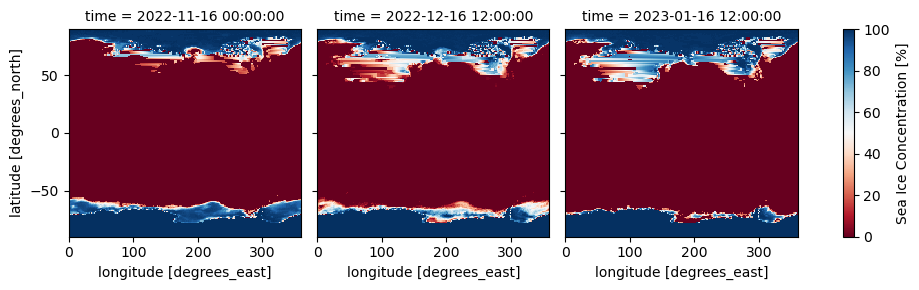

### 👉 Previous simple neighbour averaging

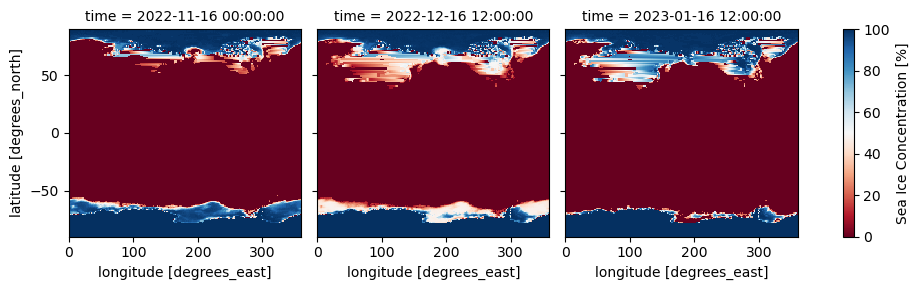

### 👉 Differences between infill methods

CPU times: user 662 ms, sys: 72.5 ms, total: 734 ms
Wall time: 732 ms


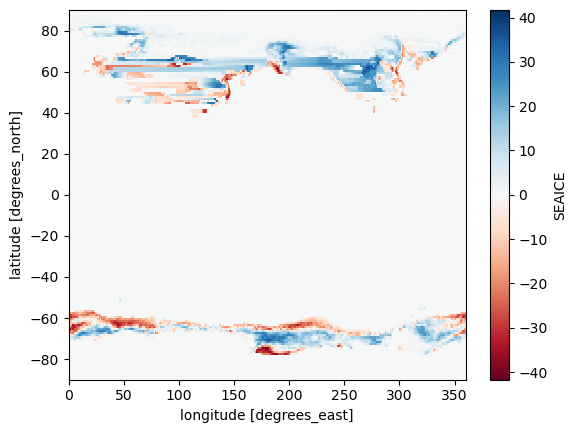

In [12]:
%%time

def fmt(arr):
    arrNums = "\n".join([
        "{:07.3f}".format(arr.min().data),
        "{:07.3f}".format(arr.median().data),
        "{:07.3f}".format(arr.mean().data),
        "{:07.3f}".format(arr.max().data),
        "---",
        ])
    return arrNums


# anomaly-climatology based reconstruction
newDec22 = climDec + aveAnom
print(fmt(newDec22))
newDec22 = newDec22.clip(min=0., max=100.)
print(fmt(newDec22))
newNovDecJan = NovDecJan.copy(deep=True)
newNovDecJan[1,] = newDec22
# anomaly-climatology averaging
display(Markdown("### 👉 Anomaly-climatology based averaging"))
newNovDecJan.plot(col="time", col_wrap=3, cmap="RdBu")
plt.show()
# simple neighbour averaging
NovDecJan[1, :, :] = newDec  # replace in tmp array
display(Markdown("### 👉 Previous simple neighbour averaging"))
NovDecJan.plot(col="time", col_wrap=3, cmap="RdBu")
plt.show()
display(Markdown("### 👉 Differences between infill methods"))
(newDec22-newDec).plot(cmap="RdBu")

### compare to previous years transition (2021-22, 2020-21, 2019-20, 2018-19, 2017-18)

### 👉 Original data

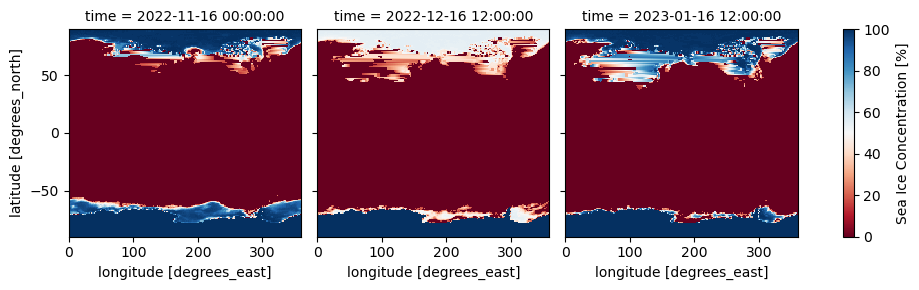

### 👉 Anomaly-climatology replacement - to be compared to previous year transitions

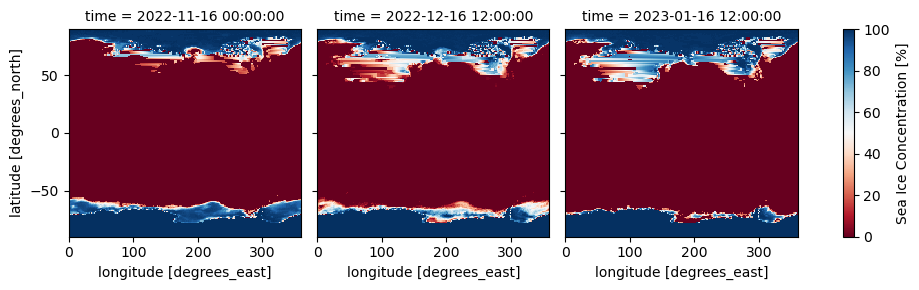

### 👉 Previous year transitions

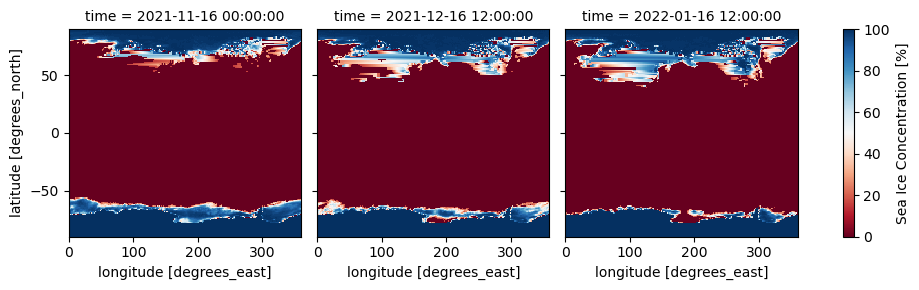

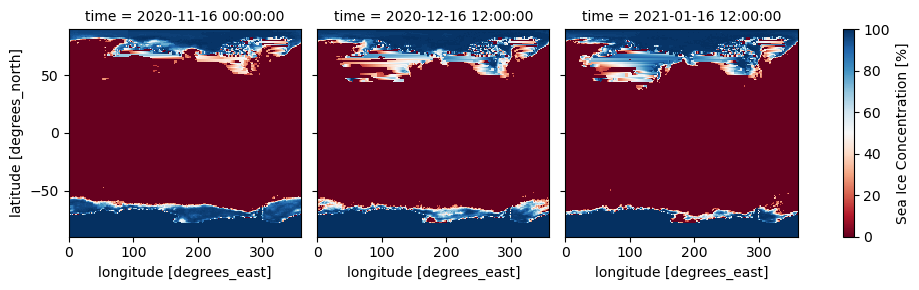

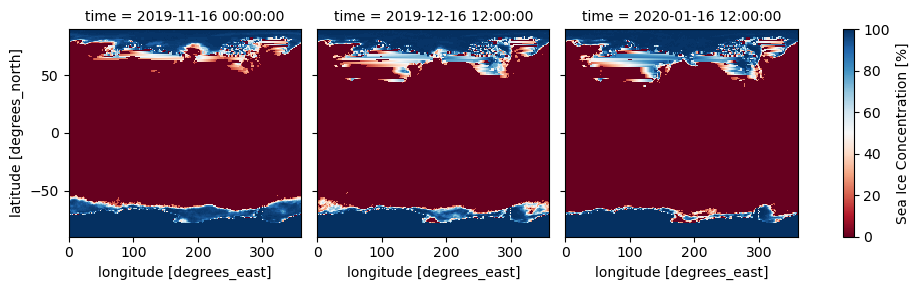

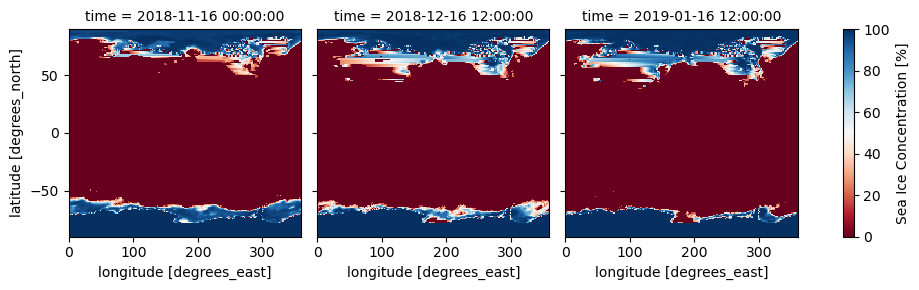

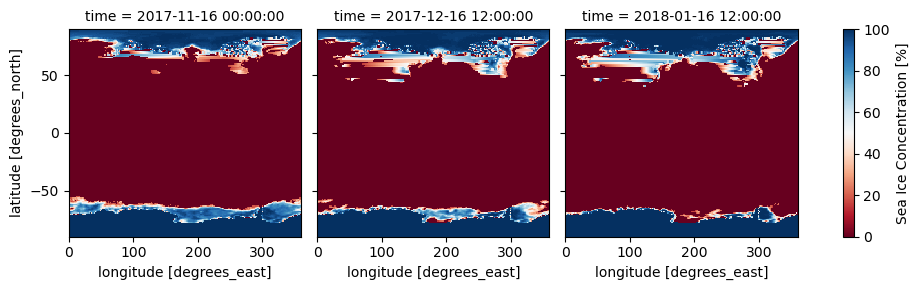

In [ ]:
display(Markdown("### 👉 Original data"))
sic.sel(time=slice("2022-11", "2023-01")).plot(col="time", col_wrap=3, cmap="RdBu")
plt.show()
display(
    Markdown(
        "### 👉 Anomaly-climatology replacement - to be compared to previous year transitions"
    )
)
newNovDecJan.plot(col="time", col_wrap=3, cmap="RdBu")
plt.show()
display(Markdown("### 👉 Previous year transitions"))
sic.sel(time=slice("2021-11", "2022-01")).plot(col="time", col_wrap=3, cmap="RdBu")
sic.sel(time=slice("2020-11", "2021-01")).plot(col="time", col_wrap=3, cmap="RdBu")
sic.sel(time=slice("2019-11", "2020-01")).plot(col="time", col_wrap=3, cmap="RdBu")
sic.sel(time=slice("2018-11", "2019-01")).plot(col="time", col_wrap=3, cmap="RdBu")
sic.sel(time=slice("2017-11", "2018-01")).plot(col="time", col_wrap=3, cmap="RdBu")

### recreate new timeseries

2025-08-04 21:40:28 UTC : Updated to replace problematic existing 2022-12 value with an anomaly-climatology infill. Calculates 2018-22 November, 2019-2023 January, and 2018-21 December monthly climatologies. From these multi-month climatologies, single-month anomalies are calculated. Nov-22 and Jan-23 anomalies are extracted, and the average of these is added to the Dec18-21 climatology to provide an infilled Dec-22 value.


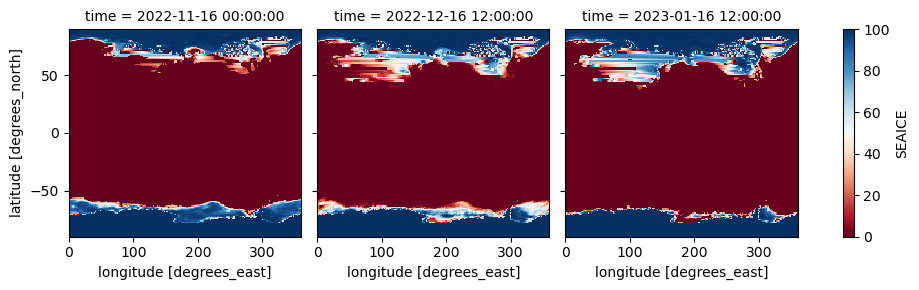

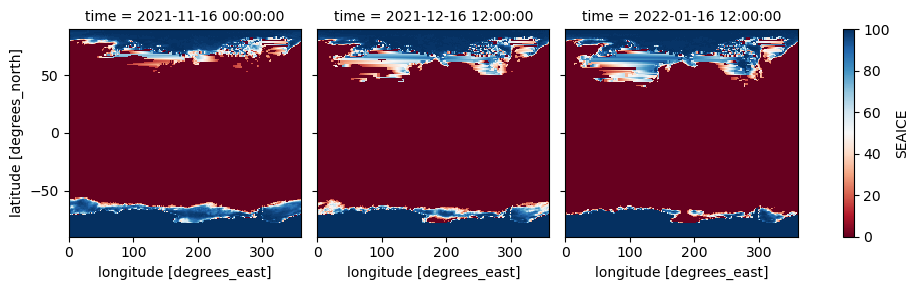

In [ ]:
sic[-2, :, :] = newDec22  # replace in tmp array
# append new global attribute noting infill info
sic.attrs = ds3.attrs.copy()
# Create new history entry
new_entry = " ".join(
    [
        f"{datetime.now(timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC ')}: Updated to replace",
        "problematic existing 2022-12 value with an anomaly-climatology infill. Calculates",
        "2018-22 November, 2019-2023 January, and 2018-21 December monthly climatologies.",
        "From these multi-month climatologies, single-month anomalies are calculated.",
        "Nov-22 and Jan-23 anomalies are extracted, and the average of these is added to",
        "the Dec18-21 climatology to provide an infilled Dec-22 value.",
    ]
)
print(new_entry)
# Prepend to history
sic.attrs["history"] = f"\n{new_entry}\n{ds3.attrs.get('history', '')}"
sic.attrs.get("history")
# sys.exit("Stopping notebook here.")
# plot
sic.sel(time=slice("2022-11", "2023-01")).plot(col="time", col_wrap=3, cmap="RdBu")
sic.sel(time=slice("2021-11", "2022-01")).plot(col="time", col_wrap=3, cmap="RdBu")

### write out new dataset to file

In [15]:
%%time
outPath = "/pscratch/sd/d/durack1/Shared/150219_AMIPForcingData/SST_1-1-10"
outFile = "MODEL.ICE.HAD187001-198110.OI198111-202301.nc"
outFileAndPath = os.path.join(outPath, outFile)
# cleanup
if os.path.exists(outFileAndPath):
    os.remove(outFileAndPath)
sic.to_netcdf(outFileAndPath)

CPU times: user 364 ms, sys: 1.05 s, total: 1.41 s
Wall time: 1.42 s


# other code samples below

### Mark examples

In [16]:
sys.exit("Stopping notebook here.")
# obs4MIPsPath = "/p/user_pub/PCMDIobs/obs4MIPs_input"
obs4MIPsPath = "/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_input"
dataPath = "MOHC/HadISST1-1/v20230526/HadISST.1.1.sst.nc"
ds = xc.open_dataset(
    os.path.join(obs4MIPsPath, dataPath),
    lon_orient=(0, 360),
)
ds["sst"][-10:, 90, -2:]

SystemExit: Stopping notebook here.

/global/u2/d/durack1/miniforge3/envs/cmor3110xcd091/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
len(ds.longitude)

In [ ]:
ds["sst"].sel(time="2022-12-16").plot()

### interrogate local non-published data

In [ ]:
# homePath = "/p/user_pub/climate_work/durack1/Shared/150219_AMIPForcingData"
homePath = "/pscratch/sd/d/durack1/Shared/150219_AMIPForcingData"
ds1 = xc.open_dataset(
    os.path.join(
        homePath, "SST_1-1-9-release/MODEL.SST.HAD187001-198110.OI198111-202301.nc"
    )
)
# ds1
ds2 = xc.open_dataset(
    os.path.join(obs4MIPsPath, "NOAA-PSL/OISST2-0/v20230526/OISST.2.0.sst.mnmean.nc")
)
# ds3 = xc.open_dataset('SST_1-1-0-release/230503/oiv2mon.202212')
# https://kpegion.github.io/Pangeo-at-AOES/examples/read-fortran-binary.html

In [ ]:
ds2

In [ ]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(18, 6),
)
fig.suptitle("2022-12", x=0.45, y=0.95, fontsize=16)

# axes is a 2 dimensional array of `GeoAxes` - flatten into 1-D array
axes = axes.flatten()

# Loop over data
for i in np.arange(0, 2):
    print("i:", i)
    if i == 0:
        data = ds1["SST"].sel(time="2022-12-16")
        lons = ds1["lon"]
        lats = ds1["lat"]
        titleTxt = "oiv2mon.202212 -> PCMDI-AMIP-1-1-9"
    elif i == 1:
        data = ds2["sst"].sel(time="2022-12-01")
        lons = ds2["lon"]
        lats = ds2["lat"]
        titleTxt = "NOAA-OISST-2-0"

    # Colour plot
    cs = axes[i].pcolor(
        lons,
        lats,
        data.squeeze(),
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        vmin=-5,
        vmax=35,
    )
    # add colorbar
    fig.colorbar(cs, ax=axes[i], fraction=0.024, pad=0.02, label="degC")
    # Title each subplot
    axes[i].set_title(titleTxt)
    # Draw the coastines
    axes[i].coastlines()

plt.tight_layout()
plt.show()